# Quantum phase estimation algorithm with Qiskit
### Anton Soldatenkov (314433)

In [1]:
from math import pi
from qiskit import QuantumCircuit, IBMQ, Aer, execute
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

In this notebook, we consider a particular case of the state estimation algorithm: $U = e^{2\pi i \varphi X}$, $\varphi = \frac 34$ with eigenvector $|u\rangle=\frac{1}{\sqrt 2}(|0\rangle + |1\rangle)$, therefore $U|u\rangle = e^{2\pi i \varphi}|u\rangle$.

Circuit of the phase estimation algorithm:
<img src="img/circuit.jpg">

To implement inverse QFT, we take the circuit of QFT:
<img src="img/qft.jpg">
and apply inverted gates in reversed order (recall that $H^\dagger=H$).

In [2]:
def qft_dagger(qc):
    qc.h(0)
    qc.cu1(-pi/2, 0, 1)
    qc.h(1)
    qc.swap(0, 1)

We calculate $U$ and $U^2$:  
$U = e^{2i\pi \varphi X} = \cos(2\pi\varphi) I+i\sin(2\pi\varphi)X =
\begin{bmatrix}
\cos 2\pi\varphi & i\sin 2\pi\varphi\\
i\sin 2\pi\varphi & \cos 2\pi\varphi\\ 
\end{bmatrix},  \\
U^2 = e^{2i\pi \varphi X} =
\begin{bmatrix}
\cos 4\pi\varphi & i\sin 4\pi\varphi\\
i\sin 4\pi\varphi & \cos 4\pi\varphi\\ 
\end{bmatrix}. \\
$  
In our particular case $\varphi = \frac{3}{4}$ we get 
$U = \begin{bmatrix}
0 & -i \\
-i & 0\\ 
\end{bmatrix}
$, $U^2 = \begin{bmatrix}
0 & -1 \\
-1 & 0\\ 
\end{bmatrix}
$.  
We can decompose $U$ and $U^2$ into the following sequence of gates:  
$U = R_{-\frac{\pi}{2}}XR_{-\frac{\pi}{2}}$ , where $R_{-\frac{\pi}{2}} = \begin{bmatrix}
1 & 0 \\
0 & -i\\
\end{bmatrix}$  is a $-\frac{\pi}{2}$ phase shift gate;  
$U^2 = ZXZ$.  
To set the third qubit to $|u\rangle = \frac{1}{\sqrt 2}(|0\rangle + |1\rangle)$ we need to apply the Hadamard gate.

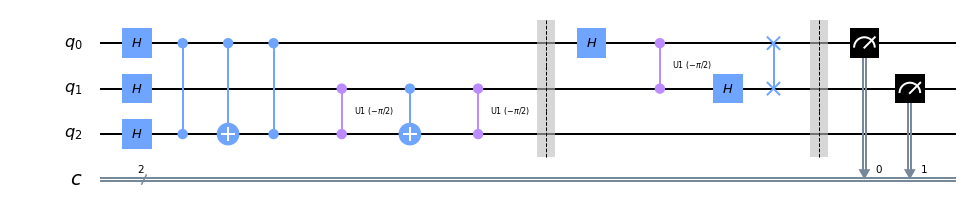

In [3]:
# Circuit implementation

qc = QuantumCircuit(3, 2) # 3 cubits, 2 classical bits

for qubit in range(3):
    qc.h(qubit)

# Controlled-U^2
qc.cz(0, 2)
qc.cx(0, 2)
qc.cz(0, 2)

# Controlled-U
qc.cu1(-pi/2, 1, 2)
qc.cx(1, 2)
qc.cu1(-pi/2, 1, 2)

qc.barrier()
qft_dagger(qc)
qc.barrier()

# Measurements
qc.measure(0, 0)
qc.measure(1, 1)

# Visualize the circuit
qc.draw(output='mpl')

We test our code on the "simulator" backend:

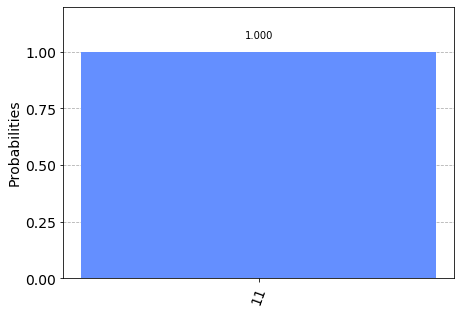

In [4]:
sumul = Aer.get_backend('qasm_simulator')
sim_result = execute(qc, backend=sumul, shots=1024).result().get_counts()
plot_histogram(sim_result)

As expected, we got `11` with probability 1, which corresponds to binary $0.11 = \frac{3}{4} = \varphi$.

Now test on a real machine:

In [5]:
provider = IBMQ.load_account()
real_device = provider.get_backend('ibmq_16_melbourne')
job = execute(qc, backend=real_device, shots=1024)
job_monitor(job)

Job Status: job has successfully run


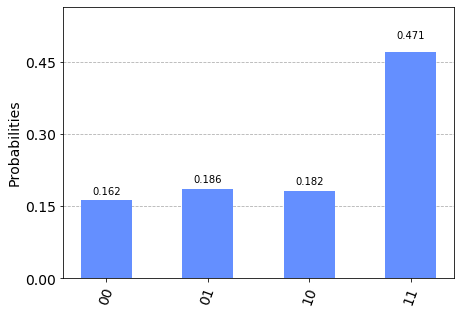

In [6]:
real_result = job.result().get_counts()
plot_histogram(real_result)

We can see that the most observable result is still `11`, however, there is a non-zero probability of measuring `00`, `01` and `10`. This can happen because of noise and gate imperfection in a real device.